This notebook should be run on a GPU machine. A T4 is sufficient. It's free in [Google
Colab](https://drive.google.com/file/d/1ehO5YfLDGawtajEe2E3QnWPQjXe7cOZs/view?usp=sharing).

**Description**: computational comparison between CAPPr and text generation.

**Estimated run time**: ~15 min.

**Environment**: dev

**Other**: run this notebook in Google Colab on a GPU.

**TODO**: add more explanation, evaluate memory requirements after fixing batching

[Motivation](#motivation)

[Setup](#setup)

[Load data and model](#load-data-and-model)

[Write prompt](#write-prompt)

[Repeat completions](#repeat-completions)

[Utilities](#utilities)

[Run CAPPr](#run-cappr)

[Run text generation](#run-text-generation)

[Plot](#plot)

# Motivation

What's the computational performance of CAPPr?

Prompt-completion classification requires as many `model()` calls as there are classes. But we can exploit the auto-regressive nature of GPT to remove repeated computation for the prompts. I'll add more on how this is done at a high-level. The low-level implementation is in [`cappr.huggingface.classify`](https://github.com/kddubey/cappr/blob/main/src/cappr/huggingface/classify.py).

There are three factors which determine runtime:
  1. The number of classes in the classification problem
  2. The number of tokens in the prompt
  3. The number of tokens in each completion/class.

The motivating idea is that sampling can't parallelized over the third factor, which
might be relatively costly depending on the task.

# Setup

If you're in Google Colab, you should uncomment and run this cell:

In [ ]:
!pip install "cappr[demos] @ git+https://github.com/kddubey/cappr.git"

In [2]:
from __future__ import annotations
from time import time
from typing import Literal

import datasets as nlp_datasets
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline

from cappr import Example
from cappr.huggingface import classify as do_cache
from cappr.huggingface import classify_no_cache as no_cache

In [3]:
assert torch.cuda.is_available(), "This experiment should be run on a GPU"

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data and model

In [5]:
def load_super_glue(task_id: str, split: str):
    return pd.DataFrame(nlp_datasets.load_dataset("super_glue", task_id, split=split))


# takes about 12 seconds
df = pd.concat(
    (load_super_glue("copa", "train"), load_super_glue("copa", "validation"))
).reset_index(
    drop=True
)  # idx column is only unique w/in splits! fuhgetaboutit

In [6]:
gpt2_name = "gpt2"  # smallest in the GPT-2 line
gpt2 = AutoModelForCausalLM.from_pretrained(gpt2_name).to(DEVICE)

tokenizer = AutoTokenizer.from_pretrained(gpt2_name)
tokenizer.pad_token_id = tokenizer.eos_token_id  # allow padding -> allow batching

# Write prompt

In [7]:
def _conjunction(question: Literal["cause", "effect"]):
    if question == "cause":
        return " because"
    elif question == "effect":
        return ", so"
    else:
        raise ValueError("question must be 'cause' or 'effect'. Got " f"{question}.")


def prompt(premise: str, question: Literal["cause", "effect"]):
    conjunction = _conjunction(question)
    return f'{premise.strip(". ")}{conjunction}'

In [8]:
def mc(*choices: str) -> str:
    choice_idxs = range(len(choices))
    choices_str = "\n".join(
        [f"{idx}. {choice}" for idx, choice in zip(choice_idxs, choices)]
    )
    return choices_str + "\n" + "Pick one from above."

In [9]:
print(mc("Green eggs", "Ham", "Scooby Dooby"))

0. Green eggs
1. Ham
2. Scooby Dooby
Pick one from above.


In [10]:
def prompt_mc(premise: str, question: Literal["cause", "effect"], *choices):
    return f"{prompt(premise, question)}\n" f"{mc(*choices)}"

In [11]:
df["prompt"] = [
    prompt(premise, question)
    for premise, question in zip(df["premise"], df["question"])
]

# Repeat completions

In [12]:
NUM_COMPLETIONS = 4 * np.arange(1, 8 + 1)
NUM_COMPLETIONS: list[int] = [2] + list(NUM_COMPLETIONS)
NUM_COMPLETIONS

[2, 4, 8, 12, 16, 20, 24, 28, 32]

We need to create a few data structures. For each `NUM_COMPLETIONS`, we need a set of `Example`s for `cappr`, and a set of multiple-choice prompts for text generation.

In [13]:
_condition = all(np.mod(NUM_COMPLETIONS, 2) == 0)
_msg = "NUM_COMPLETIONS can only contain even numbers"
assert _condition, _msg

examples: dict[int, list[Example]] = dict()

for n in NUM_COMPLETIONS:
    # there are 2 completoins/"choices" in COPA
    multiplier = int(n / 2)
    # lstrip to ensure prompt and completion are only separated by a space, in case
    # you wanna check that cache and no-cache pred probs are w/in 10-4 of each other
    df[f"_choices_{n}"] = list(
        zip(
            *[
                df["choice1"].str.lower().str.lstrip(),
                df["choice2"].str.lower().str.lstrip(),
            ]
            * multiplier
        )
    )
    examples[n] = [
        Example(
            prompt=record["prompt"], completions=record[f"_choices_{n}"], prior=None
        )
        for record in df.to_dict("records")
    ]
    df[f"prompt_mc_{n}"] = [
        prompt_mc(record["premise"], record["question"], *record[f"_choices_{n}"])
        for record in df.to_dict("records")
    ]

In [14]:
examples[8][0].completions

('the sun was rising.',
 'the grass was cut.',
 'the sun was rising.',
 'the grass was cut.',
 'the sun was rising.',
 'the grass was cut.',
 'the sun was rising.',
 'the grass was cut.')

In [15]:
print(df["prompt_mc_8"].iloc[0])

My body cast a shadow over the grass because
0. the sun was rising.
1. the grass was cut.
2. the sun was rising.
3. the grass was cut.
4. the sun was rising.
5. the grass was cut.
6. the sun was rising.
7. the grass was cut.
Pick one from above.


# Utilities

In [16]:
def time_func(func, *args, num_replications: int = 10, **kwargs) -> list[float]:
    """
    Returns a list, `times`, where `times[i]` is the time it took to run
    `func(*args, **kwargs)` at replication `i` for `i in range(num_replications)`.
    """
    times = []
    for _ in range(num_replications):
        time_start = time()
        _ = func(*args, **kwargs)
        time_end = time()
        times.append(time_end - time_start)
    return times

I don't think we need to send the whole dataset to each function. It seems like the replication we care about is over repeated runs, not batches. So let's limit the dataset to the first 3 batches of size 16. The batch size is constant across all function calls for CAPPr and text generation. It seems to be close to the max a Colab GPU can handle.

In [17]:
dataloader_kwargs = dict(batch_size=16, shuffle=False)
num_batches = 3
num_replications = 5

In [18]:
num_examples = num_batches * dataloader_kwargs["batch_size"]

We just have to remember to slice the head off of each dataset!

We'll store the results in this dict

In [19]:
def nan_array(shape: tuple):
    a = np.empty(shape)
    a[:] = np.NaN
    return a


_shape = (len(NUM_COMPLETIONS), num_replications)

func_to_times: dict[str, np.ndarray] = {
    "cappr (no cache)": nan_array(_shape),
    "cappr (cache)": nan_array(_shape),
    "text generation": nan_array(_shape),
    "text generation\n(1 token)": nan_array(_shape),
}

# Run CAPPr

In [20]:
# warm up model just in case
_ = gpt2(input_ids=torch.tensor([[0,1]], device=DEVICE))

In [21]:
# some common arguments
model_and_tokenizer = (gpt2, tokenizer)
batch_size = dataloader_kwargs['batch_size']

In [ ]:
for i, num_completions in tqdm(
    enumerate(NUM_COMPLETIONS), total=len(NUM_COMPLETIONS), desc="Loop # completions"
):
    examples_sample = examples[num_completions][:num_examples]
    times = time_func(
        no_cache.predict_examples,
        examples_sample,
        num_replications=num_replications,
        model_and_tokenizer=model_and_tokenizer,
        batch_size=batch_size,
    )
    func_to_times["cappr (no cache)"][i] = times

In [23]:
assert (
    np.sum(np.isnan(func_to_times["cappr (no cache)"])) == 0
), "Some times are missing!"

In [ ]:
for i, num_completions in tqdm(
    enumerate(NUM_COMPLETIONS), total=len(NUM_COMPLETIONS), desc="Loop # completions"
):
    examples_sample = examples[num_completions][:num_examples]
    times = time_func(
        do_cache.predict_examples,
        examples_sample,
        num_replications=num_replications,
        model_and_tokenizer=model_and_tokenizer,
        batch_size=batch_size,
    )
    func_to_times["cappr (cache)"][i] = times

In [25]:
assert np.sum(np.isnan(func_to_times["cappr (cache)"])) == 0, "Some times are missing!"

# Run text generation

In [26]:
max_new_tokens = len(tokenizer("\n\nAnswer A").input_ids)
generator = pipeline(
    "text-generation", model=gpt2_name, max_new_tokens=max_new_tokens, device=DEVICE
)
generator.tokenizer.padding_side = "left"  # for sampling
generator.tokenizer.pad_token_id = generator.model.config.eos_token_id

We need to provide the `generator` with a torch `Dataset`. Let's set those up for each `NUM_COMPLETIONS`

In [27]:
class TextsDataset(Dataset):
    def __init__(self, texts: list[str]):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index: int):
        return self.texts[index]

In [28]:
mc_datasets = {n: TextsDataset(df[f"prompt_mc_{n}"].tolist()) for n in NUM_COMPLETIONS}

In [29]:
def classification_via_sampling(
    generator,
    mc_dataset: TextsDataset,
    batch_size: int = dataloader_kwargs["batch_size"],
):
    for _ in tqdm(
        generator(
            mc_dataset,
            # suppress "Setting pad_token_id..." stdout
            pad_token_id=generator.tokenizer.eos_token_id,
            batch_size=batch_size,
        ),
        total=len(mc_dataset),
        desc="sampling",
    ):
        pass  # we don't need the output for anything

In [ ]:
for i, num_completions in tqdm(
    enumerate(NUM_COMPLETIONS), total=len(NUM_COMPLETIONS), desc="Loop # completions"
):
    mc_dataset_sample = mc_datasets[num_completions][:num_examples]
    times = time_func(
        classification_via_sampling,
        generator,
        mc_dataset_sample,
        num_replications=num_replications,
        batch_size=batch_size,
    )
    func_to_times["text generation"][i] = times

In [31]:
assert np.sum(np.isnan(func_to_times["text generation"])) == 0, "Some times are missing!"

In [32]:
max_new_tokens = 1
generator1 = pipeline(
    "text-generation", model=gpt2_name, max_new_tokens=max_new_tokens, device=DEVICE
)
generator1.tokenizer.padding_side = "left"  # for sampling
generator1.tokenizer.pad_token_id = generator1.model.config.eos_token_id

Only one model call is made, but it's on a longer sequence length. Plain attention has quadratic complexity, so this could still take a while.

In [ ]:
for i, num_completions in tqdm(
    enumerate(NUM_COMPLETIONS), total=len(NUM_COMPLETIONS), desc="Loop # completions"
):
    mc_dataset_sample = mc_datasets[num_completions][:num_examples]
    times = time_func(
        classification_via_sampling,
        generator1,
        mc_dataset_sample,
        num_replications=num_replications,
        batch_size=batch_size,
    )
    func_to_times["text generation\n(1 token)"][i] = times

In [34]:
assert np.sum(np.isnan(func_to_times["text generation\n(1 token)"])) == 0, "Some times are missing!"

# Plot

Aggregate w/ median. TODO: show IQR or something

In [35]:
times_df = pd.DataFrame(
    {func: np.median(times, axis=1) for func, times in func_to_times.items()}
)
times_df["# classes"] = NUM_COMPLETIONS
times_df = times_df.set_index("# classes")

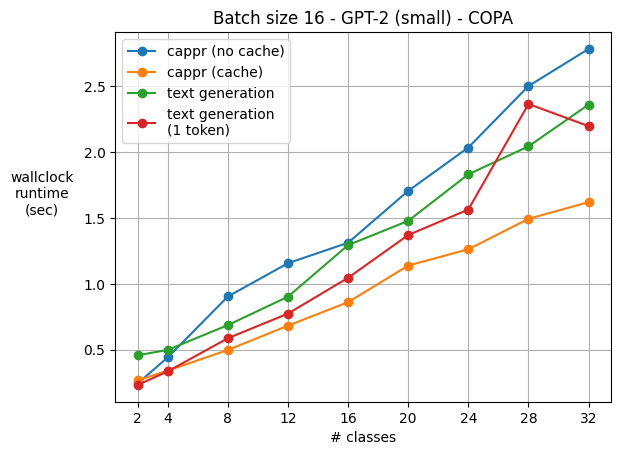

In [36]:
ax = times_df.plot(
    marker="o", title=f"Batch size {batch_size} - GPT-2 (small) - COPA", grid=True
)
ax.set_ylabel("wallclock\nruntime\n(sec)", rotation="horizontal", labelpad=30)
ax.set_xticks(NUM_COMPLETIONS)

In [37]:
from google.colab import files

fig = ax.get_figure()
fig.patch.set_facecolor("white")
filename = f"batch_size_{batch_size}.png"
fig.savefig(filename, bbox_inches="tight")  # don't cutoff ylabel
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
num_examples

48

In [39]:
num_replications

5

Caption:

[COPA](https://people.ict.usc.edu/~gordon/copa.html) dataset, repeating the choices to
simulate multi-class classification tasks. [GPT-2 (small)](https://huggingface.co/gpt2)
was run on a T4 GPU. 48 classification inputs were processed in batches of size 16. For
a controlled runtime comparison, GPU RAM was held (roughly) constant for each method and
each number of classes. Each point in the graph is a median of 5 runs. For text
generation, exactly 4 tokens were generated for each prompt, which is the number of
tokens in ``'\n\nAnswer A'``. 1-token times are also shown. But for COPA (and other
multiple-choice style prompts), that may result in lower zero-shot accuracy, as most of
the sampled choices come after the first token.